## An end-to-end example: A linear classifier in pure TensorFlow
covariance matrix = shape of the point cloud of data

We’ll reuse the same covariance matrix for both point clouds, but we’ll use two different mean values—the point clouds will have the same shape, but different positions

In [2]:
import numpy as np

#gerar duas classes com pontos aleatorios
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], 
    cov=[[1, 0.5],[0.5, 1]], 
    size=num_samples_per_class
    )
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], 
    cov=[[1, 0.5],[0.5, 1]], 
    size=num_samples_per_class)


In the preceding code, negative_samples and positive_samples are both arrays with shape (1000, 2). Let’s stack them into a single array with shape (2000, 2).

In [3]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)


Generating the corresponding targets (0 and 1) -> shape = 2000,1

In [4]:
targets = np.vstack((np.zeros((num_samples_per_class,1), dtype="float32"),
                    np.ones((num_samples_per_class, 1),dtype="float32")))

plotting the two point classes

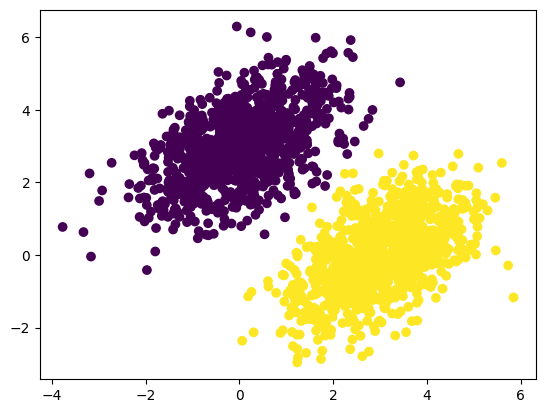

In [46]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:,0])
plt.show()


Now let’s create a linear classifier that can learn to separate these two blobs. A linear classifier is an affine transformation (prediction = W • input + b) trained to minimize the square of the difference between predictions and the targets.

Let’s create our variables, W and b, initialized with random values and with zeros, respectively.

In [ ]:
import tensorflow as tf
input_dim = 2 #os inputs sao pontos 2d
output_dim = 1 #predições serão um score por amostra, perto de 0 se a classe predita for 0, etc
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim))) #W.shape = (2,1)
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))


a função do forward pass:

In [49]:

def model(inputs):
    return tf.matmul(inputs, W) + b

Because our linear classifier operates on 2D inputs, W is really just two scalar coefficients, w1 and w2:

 W = [[w1], [w2]]. 
 
 Meanwhile, b is a single scalar coefficient. As such, for a given input point [x, y], its prediction value is prediction = [[w1], [w2]] • [x, y] + b = w1 * x + w2 * y + b.

### The mean squared error loss function

In [50]:
def square_loss(targets, predictions): 
    #per_sample_losses will be a tensor with the same shape as targets and predicitions
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

### the training step function

In [ ]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        #forward pass dentro do scope do gradiente
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss,[W,b])
    W.assign_sub(grad_loss_wrt_W * learning_rate) #otimiza os pesos na direçao contraria ao gradiente da perda com relação ao peso limitado pelo learning rate
    b.assign_sub(grad_loss_wrt_b * learning_rate) #atualiza o bias
    return loss

For simplicity, we’ll do batch training instead of mini-batch training: we’ll run each training step (gradient computation and weight update) for all the data, rather than iterate over the data in small batches. On one hand, this means that each training step will take much longer to run, since we’ll compute the forward pass and the gradients for 2,000 samples at once. On the other hand, each gradient update will be much more effective at reducing the loss on the training data, since it will encompass information from all training samples instead of, say, only 128 random samples. As a result, we will need many fewer steps of training, and we should use a larger learning rate than we would typically use for mini-batch training (we’ll use learning_rate = 0.1, defined in listing 3.20).

### batch training loop

In [53]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.3742
Loss at step 1: 0.0816
Loss at step 2: 0.0672
Loss at step 3: 0.0622
Loss at step 4: 0.0587
Loss at step 5: 0.0557
Loss at step 6: 0.0529
Loss at step 7: 0.0503
Loss at step 8: 0.0480
Loss at step 9: 0.0459
Loss at step 10: 0.0440
Loss at step 11: 0.0423
Loss at step 12: 0.0407
Loss at step 13: 0.0392
Loss at step 14: 0.0379
Loss at step 15: 0.0367
Loss at step 16: 0.0356
Loss at step 17: 0.0346
Loss at step 18: 0.0336
Loss at step 19: 0.0328
Loss at step 20: 0.0320
Loss at step 21: 0.0313
Loss at step 22: 0.0307
Loss at step 23: 0.0301
Loss at step 24: 0.0296
Loss at step 25: 0.0291
Loss at step 26: 0.0287
Loss at step 27: 0.0283
Loss at step 28: 0.0279
Loss at step 29: 0.0276
Loss at step 30: 0.0273
Loss at step 31: 0.0270
Loss at step 32: 0.0267
Loss at step 33: 0.0265
Loss at step 34: 0.0263
Loss at step 35: 0.0261
Loss at step 36: 0.0259
Loss at step 37: 0.0258
Loss at step 38: 0.0256
Loss at step 39: 0.0255


Because our targets are zeros and ones, a given input point will be classified as “0” if its prediction value is below 0.5, and as “1” if it is above 0.5

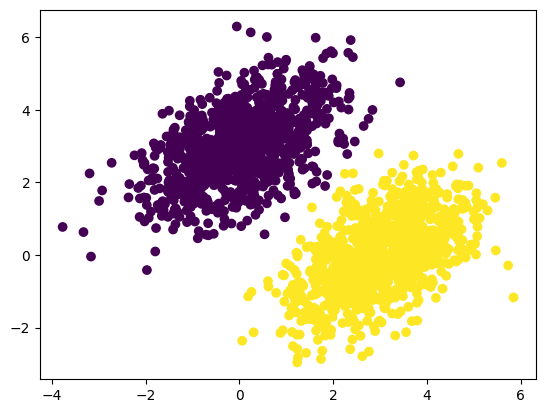

In [54]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:,0] > 0.5)
plt.show()

Recall that the prediction value for a given point [x, y] is simply prediction == [[w1], [w2]] • [x, y] + b == w1 * x + w2 * y + b. 

Thus, class 0 is defined as w1 * x + w2 * y + b < 0.5, and class 1 is defined as w1 * x + w2 * y + b > 0.5.

 You’ll notice that what you’re looking at is really the equation of a line in the 2D plane: w1 * x + w2 * y + b = 0.5. Above the line is class 1, and below the line is class 0. 
 
 You may be used to seeing line equations in the format y = a * x + b; in the same format, our line becomes y = - w1 / w2 * x + (0.5 - b) / w2.

### plotting the line

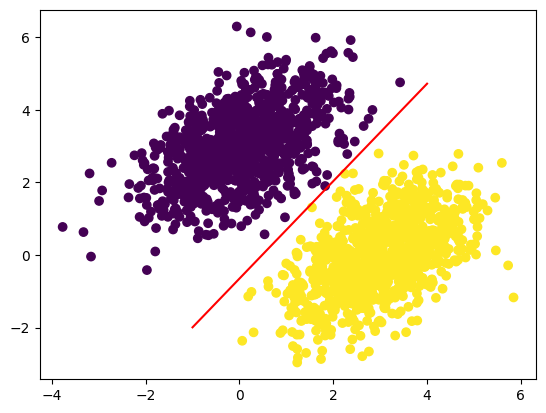

In [55]:
x = np.linspace(-1, 4, 100) #generate 100 numberos regularmente espaçados
#entre -1 e 4 que vao ser usados pra plotar a reta
#abaixo, a equação da reta:
y = -W[0] / W[1] * x + (0.5 - b) / W[1] #equação da reta
plt.plot(x,y,"-r") #-r = red line
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

This is really what a linear classifier is all about: finding the parameters of a line (or, in higher-dimensional spaces, a hyperplane) neatly separating two classes of data.